# Factor Momentum (US)

We explore if factor out-performance persists in US factor/strategy indices.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices <- Indices()
eqUs <- EquitiesUs()

In [2]:
barclaysIndices <- c('BXIIMUTU', #Momentum
                    'BXIIKUTU', #Quality
                    'BXIILUTU', #Low Volatility
                    'BXIIVUTU' #Value
                    )

etfs <- c('SPY', #large-cap
         'MDY' #mid-cap
         )

indexNames <- c(barclaysIndices, etfs)

startDate <- as.Date('2005-01-01')
endDate <- as.Date('2019-12-30')

In [3]:
monthlies <- NULL
for(iName in barclaysIndices){
    px <- indices$BarclaysTimeSeries() %>%
        filter(TICKER == iName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
    monthlies <- merge.xts(monthlies, Common.NormalizeMonthlyDates(monthlyReturn(xts(px$CLOSE, px$TIME_STAMP))))
}

for(iName in etfs){
    px <- eqUs$EodAdjustedTimeSeries() %>%
        filter(SYMBOL == iName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
    monthlies <- merge.xts(monthlies, Common.NormalizeMonthlyDates(monthlyReturn(xts(px$CLOSE, px$TIME_STAMP))))
}

monthlies <- monthlies[-1,]
monthlies <- monthlies[-nrow(monthlies), ]
names(monthlies) <- indexNames

In [4]:
allRets <- na.omit(merge(monthlies, stats::lag(monthlies, -1)))

In [5]:
print(head(allRets))

               BXIIMUTU    BXIIKUTU     BXIILUTU     BXIIVUTU         SPY
2005-02-20  0.046434389  0.02855257  0.016813255  0.057713340  0.02090386
2005-03-20 -0.008450095 -0.01881229 -0.005932797 -0.006109853 -0.02213380
2005-04-20 -0.062367363 -0.02648002  0.003320461 -0.025912348 -0.01873516
2005-05-20  0.050360705  0.04027365  0.011172692  0.029905671  0.03222462
2005-06-20  0.049010988 -0.00949237 -0.006504013  0.025095326 -0.00251088
2005-07-20  0.040617447  0.02945177  0.019995593  0.034505814  0.03826145
                   MDY   BXIIMUTU.1  BXIIKUTU.1   BXIILUTU.1   BXIIVUTU.1
2005-02-20  0.03640982 -0.008450095 -0.01881229 -0.005932797 -0.006109853
2005-03-20 -0.01633987 -0.062367363 -0.02648002  0.003320461 -0.025912348
2005-04-20 -0.03712625  0.050360705  0.04027365  0.011172692  0.029905671
2005-05-20  0.05710342  0.049010988 -0.00949237 -0.006504013  0.025095326
2005-06-20  0.02203182  0.040617447  0.02945177  0.019995593  0.034505814
2005-07-20  0.05133733  0.016128131 -0

## Buy whatever gave highest returns in the last 12-months

In [6]:
lb <- 12
factorMomXts <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        cumRets <- c(cumRets, as.numeric(Return.cumulative(X[,i])))
    }
    maxIndex <- which.max(cumRets)
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

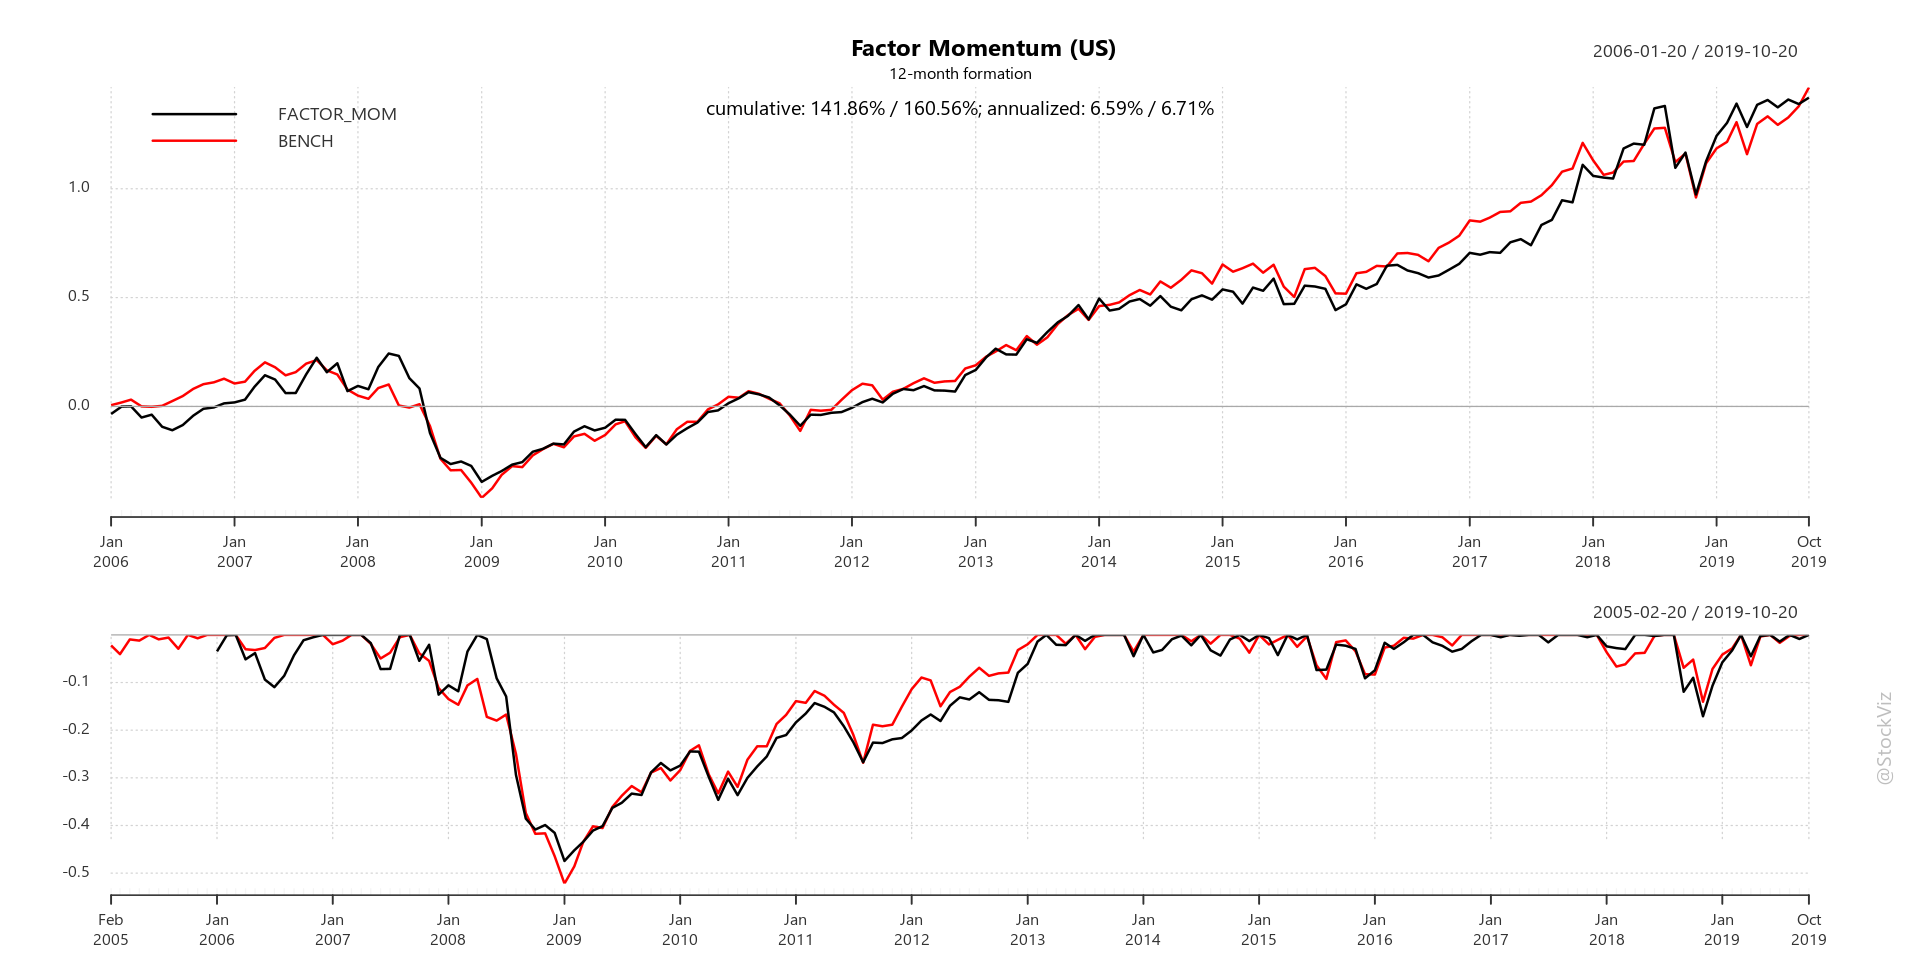

In [7]:
toPlot <- merge(factorMomXts$RET, allRets[, 'SPY.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Momentum (US)", "12-month formation")

## Buy whatever had the highest average returns over the last 6, 7, 8, 9, 10, 11 and 12-months

In [8]:
lb <- 12
factorMomXts2 <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        totalRet <- as.numeric(Return.cumulative(X[7:12,i])) +
            as.numeric(Return.cumulative(X[6:12,i])) +
            as.numeric(Return.cumulative(X[5:12,i])) +
            as.numeric(Return.cumulative(X[4:12,i])) + 
            as.numeric(Return.cumulative(X[3:12,i])) +
            as.numeric(Return.cumulative(X[2:12,i])) +
            as.numeric(Return.cumulative(X[1:12,i]))
        cumRets <- c(cumRets, totalRet/7)
    }
    maxIndex <- which.max(cumRets)
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts2 <- na.omit(factorMomXts2)
names(factorMomXts2) <- c('F', 'RET')

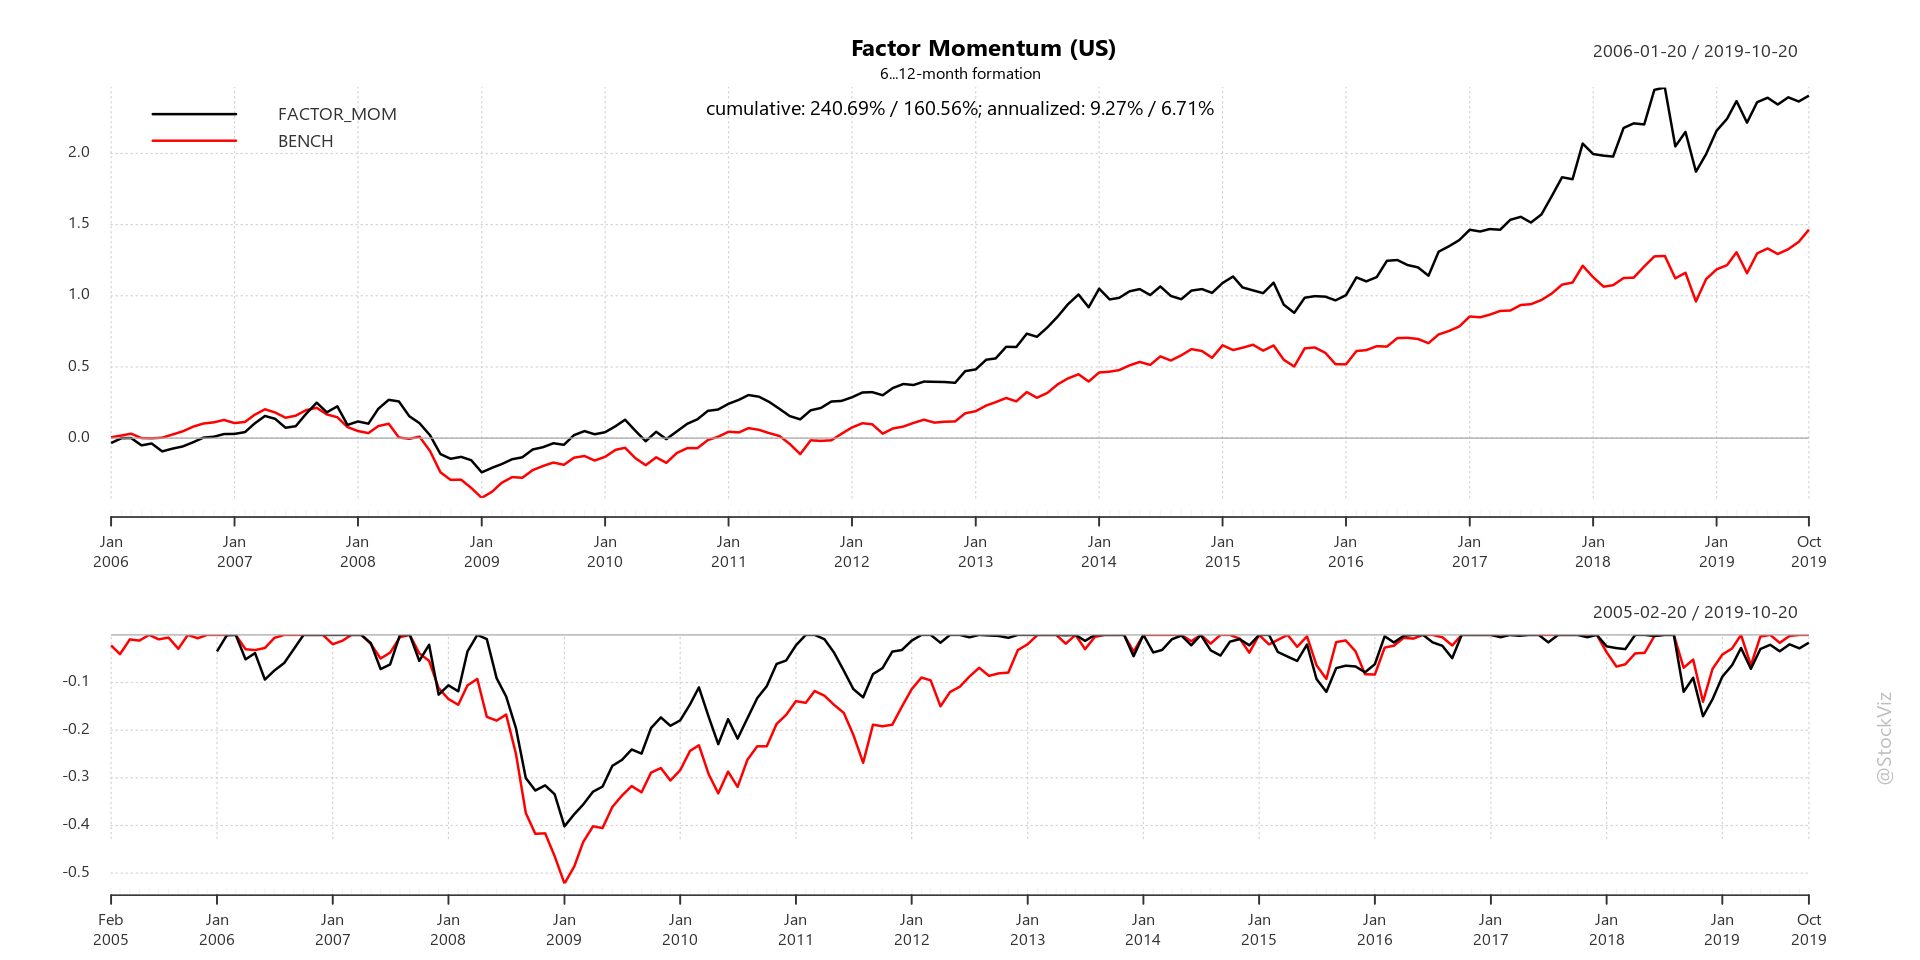

In [9]:
toPlot <- merge(factorMomXts2$RET, allRets[, 'SPY.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Momentum (US)", "6...12-month formation")

## Buy whatever gave the highest return the previous month

In [10]:
lb <- 1
factorMomXts <- rollapply(allRets, lb, function(X){
    maxIndex <- as.numeric(which.max(X[, 1:length(indexNames)]))
    return(xts(matrix(c(maxIndex, X[lb, maxIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

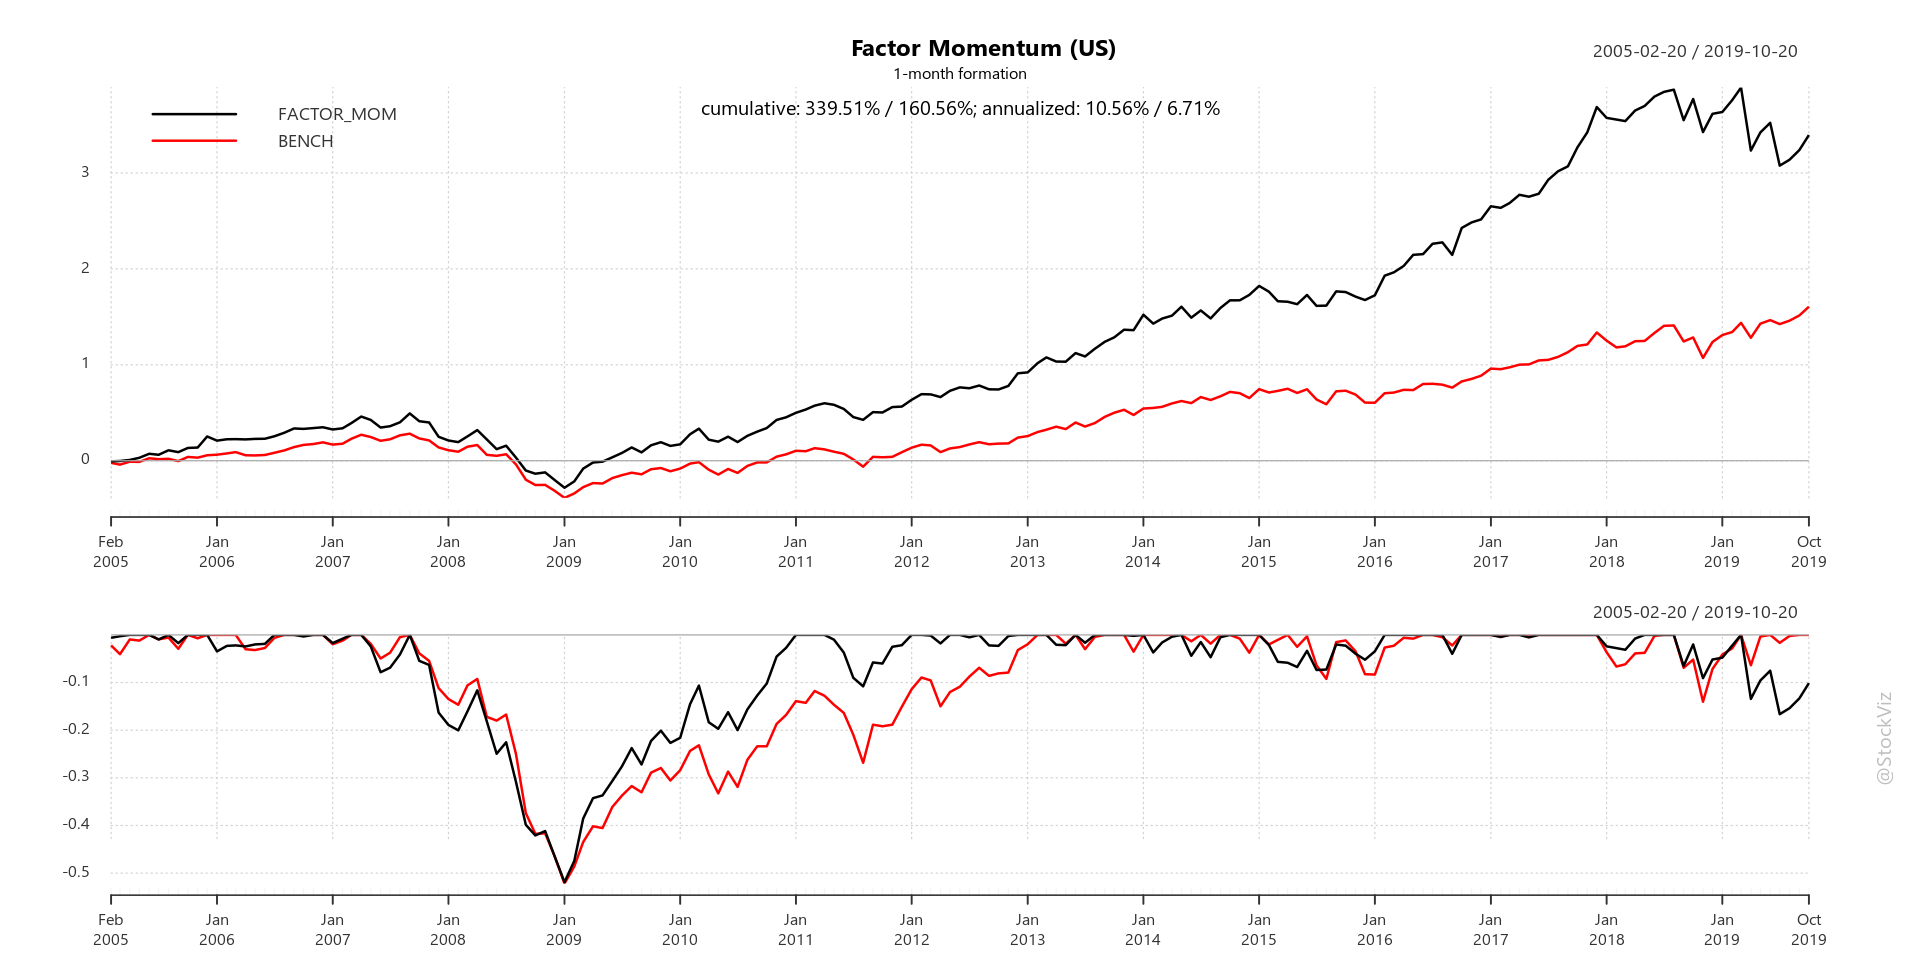

In [11]:
toPlot <- merge(factorMomXts$RET, allRets[, 'SPY.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Momentum (US)", "1-month formation")

## Buy whatever gave lowest returns in the last 12-months

In [12]:
factorMomXts <- rollapply(allRets, lb, function(X){
    cumRets <- c()
    for(i in 1:length(indexNames)){
        cumRets <- c(cumRets, as.numeric(Return.cumulative(X[,i])))
    }
    minIndex <- which.min(cumRets)
    return(xts(matrix(c(minIndex, X[lb, minIndex + length(indexNames)]), nrow=1), last(index(X))))
}, by.column = F)

factorMomXts <- na.omit(factorMomXts)
names(factorMomXts) <- c('F', 'RET')

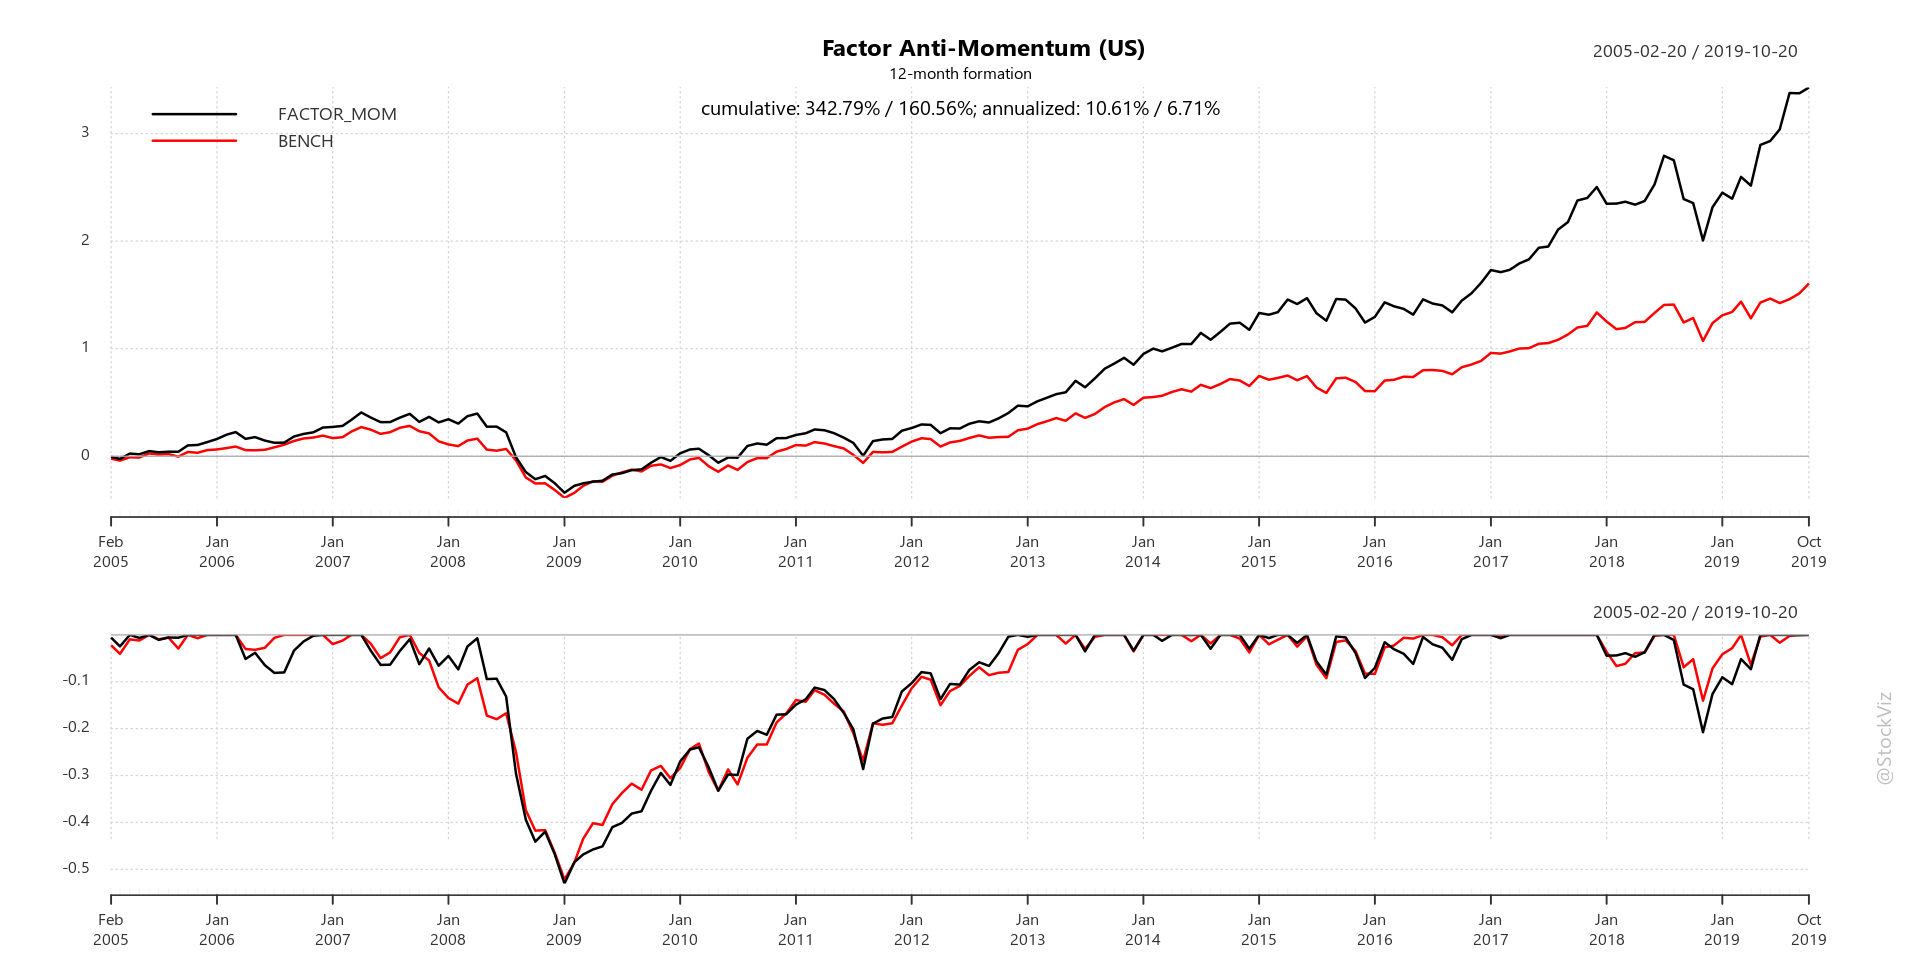

In [13]:
toPlot <- merge(factorMomXts$RET, allRets[, 'SPY.1'])
names(toPlot) <- c('FACTOR_MOM', 'BENCH')
Common.PlotCumReturns(toPlot, "Factor Anti-Momentum (US)", "12-month formation")

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!